## Panel 3A in Bloniasz, Oyama, Stephen (2024)

Panel 1 intersection at frequency=13.626
Panel 2 intersection at frequency=13.626
Panel 3 intersection at frequency=13.626


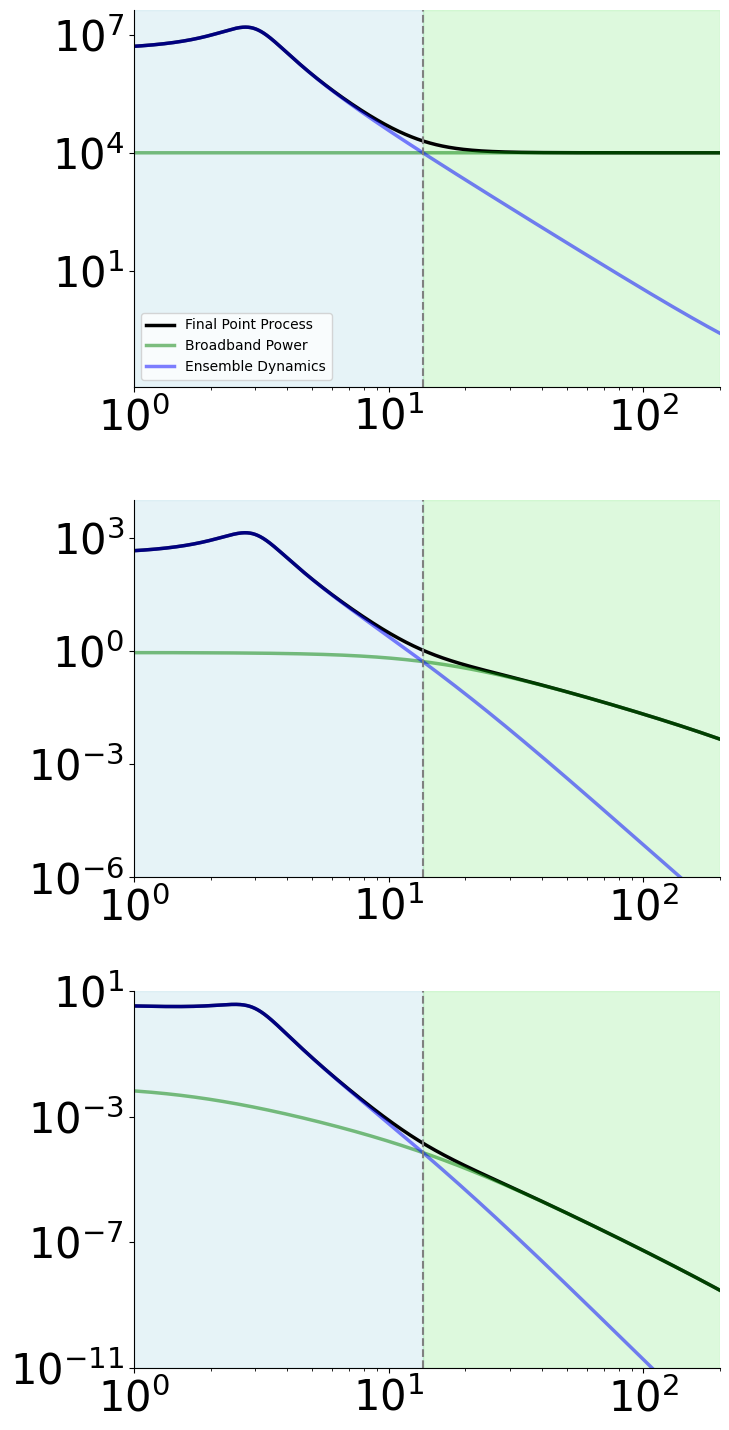

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd
import nitime.algorithms as tsa
import nitime.utils as tsu
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks

# Import your package classes
from filtered_point_process.model import Model
from filtered_point_process.point_processes.filtered_point_process import FilteredPointProcess

# 1. Define AR model parameters using new syntax
model_name = "ar"
model_params = {
    "ar_coeffs": [1.9897557323136878, -0.9901],
    "white_noise_variance": 0.7,
    "lambda_0": [1e4]
}

simulation_params = {
    "fs": 1000,       # sampling frequency
    "simulate": False, # run simulation on init
    "seed": 45        # reproducible seed
}

# 2. Instantiate and simulate the model
model = Model(
    model_name=model_name,
    model_params=model_params,
    simulation_params=simulation_params
)

# 3. Create filtered point process with GABA and 1/f filters
filters_dict = {"GABA": "GABA", "1/f": "1/f"}
fpp = FilteredPointProcess(
    model=model,
    filters=filters_dict,
    filter_params=None
)

# 4. Extract raw PP spectrum and CIF spectrum from decompositions
frequencies    = fpp.frequencies
decomp         = fpp.decompositions[0]
pp_rate        = decomp["lambda_only"]    # broadband component
cif_PSD        = decomp["cif"]            # theoretical CIF spectrum
total_pp_PSD   = pp_rate + cif_PSD        # full point-process PSD

# 5. Compute filtered spectra via the same get_spectra / get_filters API
spectra = fpp.get_final_spectrum()
filt   = fpp.filter_instances

total_1         = total_pp_PSD * fpp.filter_instances['GABA'].kernel_spectrum
filtered_rate_1 = pp_rate * fpp.filter_instances['GABA'].kernel_spectrum
filtered_cif_1  = cif_PSD * fpp.filter_instances['GABA'].kernel_spectrum

total_2         = total_pp_PSD * fpp.filter_instances['GABA'].kernel_spectrum * fpp.filter_instances['1/f'].kernel_spectrum
filtered_rate_2 = pp_rate * fpp.filter_instances['GABA'].kernel_spectrum * fpp.filter_instances['1/f'].kernel_spectrum
filtered_cif_2  = cif_PSD * fpp.filter_instances['GABA'].kernel_spectrum * fpp.filter_instances['1/f'].kernel_spectrum

# Helper to find intersections
def find_intersection(x, y1, y2):
    """
    Find intersection points where y1 and y2 cross, considering only x > 0.
    Returns arrays of x and y1 values at crossing indices.
    """
    # Mask to strictly positive frequencies
    mask = x > 0
    x_pos = x[mask]
    y1_pos = y1[mask]
    y2_pos = y2[mask]
    # Compute sign changes
    diff = y1_pos - y2_pos
    idx = np.argwhere(np.diff(np.sign(diff))).flatten()
    if idx.size == 0:
        return np.array([]), np.array([])
    return x_pos[idx], y1_pos[idx]

# 6. Plotting configuration (identical to previous figure)
plt.rcParams["font.size"]      = 30
plt.rcParams["axes.titlesize"] = 30
plt.rcParams["axes.labelsize"] = 30
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams["legend.fontsize"] = 10

fig, axs = plt.subplots(3, 1, figsize=(8, 15))

# Panel 1: raw PP, broadband, and CIF
axs[0].loglog(frequencies, total_pp_PSD, label="Final Point Process", color="black", linewidth=2.5)
axs[0].loglog(frequencies, pp_rate,        label="Broadband Power",      color="green", alpha=0.5, linewidth=2.5)
axs[0].loglog(frequencies, cif_PSD,        label="Ensemble Dynamics",     color="blue",  alpha=0.5, linewidth=2.5)
axs[0].set_xlim([1, 200])
axs[0].legend(loc="lower left")

x_int, _ = find_intersection(frequencies, cif_PSD, pp_rate)
if x_int.size > 0:
    print(f"Panel 1 intersection at frequency={x_int[0]:.3f}")
    axs[0].axvline(x=x_int[0], color="gray", linestyle="--")
    axs[0].axvspan(1, x_int[0], color="lightblue", alpha=0.3)
    axs[0].axvspan(x_int[0], 200,  color="lightgreen", alpha=0.3)

# Panel 2: after GABA filter
axs[1].loglog(frequencies, total_1,                         label="Final Point Process (GABA)",      color="black", linewidth=2.5)
axs[1].loglog(frequencies, filtered_rate_1, label="Broadband Power (GABA)",      color="green", alpha=0.5, linewidth=2.5)
axs[1].loglog(frequencies, filtered_cif_1 , label="Ensemble Dynamics (GABA)",     color="blue",  alpha=0.5, linewidth=2.5)
axs[1].set_xlim([1, 200])
axs[1].set_ylim([1e-6, 1e4])

x_int, _ = find_intersection(frequencies, filtered_rate_1, filtered_cif_1)
if x_int.size > 0:
    print(f"Panel 2 intersection at frequency={x_int[0]:.3f}")
    axs[1].axvline(x=x_int[0], color="gray", linestyle="--")
    axs[1].axvspan(1, x_int[0], color="lightblue", alpha=0.3)
    axs[1].axvspan(x_int[0], 200,  color="lightgreen", alpha=0.3)

# Panel 3: after GABA + 1/f filters
axs[2].loglog(frequencies, total_2,                           label="Final Point Process (GABA+1/f)", color="black", linewidth=2.5)
axs[2].loglog(frequencies, filtered_rate_2, label="Broadband Power (GABA+1/f)", color="green", alpha=0.5, linewidth=2.5)
axs[2].loglog(frequencies, filtered_cif_2 , label="Ensemble Dynamics (GABA+1/f)",color="blue",  alpha=0.5, linewidth=2.5)
axs[2].set_xlim([1, 200])
axs[2].set_ylim([1e-11, 1e1])

x_int, _ = find_intersection(frequencies, filtered_rate_2, filtered_cif_2)
if x_int.size > 0:
    print(f"Panel 3 intersection at frequency={x_int[0]:.3f}")
    axs[2].axvline(x=x_int[0], color="gray", linestyle="--")
    axs[2].axvspan(1, x_int[0], color="lightblue", alpha=0.3)
    axs[2].axvspan(x_int[0], 200,  color="lightgreen", alpha=0.3)

# Remove top/right spines
for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()
